In [1]:
import datetime
from functools import lru_cache
from textwrap import dedent

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pystow
import seaborn as sns
import numpy as np
from indra.assemblers.english import EnglishAssembler
from indra.literature import pubmed_client
from indra.preassembler import Preassembler
from indra.sources import SOURCE_INFO
from indra.tools.assemble_corpus import run_preassembly
from IPython.display import Markdown, display
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tabulate import tabulate
from tqdm.auto import tqdm
from indra.statements import stmt_from_json, Evidence
from indra.belief import BeliefScorer, SimpleScorer
from collections import Counter, defaultdict
from statsmodels.stats.multitest import multipletests

import json
from indra_cogex.analyses.context_specificity_analysis import df_binomtest, get_norm_counts_df, get_raw_counts_df
from indra_cogex.client import Neo4jClient, get_node_counter, get_stmts_for_stmt_hashes
from indra_cogex.info import env
from indra.databases.mesh_client import is_disease
from scipy.stats import binomtest, linregress

set_matplotlib_formats("svg")

In [2]:
env()

Key,Value
OS,posix
Platform,Darwin
Release,22.1.0
Time,Fri Jan 13 16:03:13 2023
Python,3.11.0
INDRA Version,1.22.0
INDRA Git Hash,fe603882718e919bd342247be92884c0876150fa
INDRA CoGEx Version,1.0.0
INDRA CoGEx Git Hash,439465dc2feba0da676d1e568d842772fa97bc99
INDRA CoGEx Branch,indra-db-summary


In [3]:
client = Neo4jClient()

INFO: [2023-01-13 16:03:13] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-13 16:03:13] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


From https://en.wikipedia.org/wiki/Tumor_necrosis_factor:

> As an adipokine, TNF promotes insulin resistance, and is associated with obesity-induced type 2 diabetes.[7] As a cytokine, TNF is used by the immune system for cell signaling. If macrophages (certain white blood cells) detect an infection, they release TNF to alert other immune system cells as part of an inflammatory response.[7]
>
> TNF signaling occurs through two receptors: TNFR1 and TNFR2.[8][9] TNFR1 is constituitively expressed on most cell types, whereas TNFR2 is restricted primarily to endothelial, epithelial, and subsets of immune cells.[8][9] TNFR1 signaling tends to be pro-inflammatory and apoptotic, whereas TNFR2 signaling is anti-inflammatory and promotes cell proliferation.[8][9] Suppression of TNFR1 signaling has been important for treatment of autoimmune disease,[10] whereas TNFR2 signaling promotes wound healing.[9] 

Ideas:

1. Compare correspondence between results on apoptotic process ([go:0006915](https://bioregistry.io/go:0006915) and cell proliferation ([go:0008283](https://bioregistry.io/go:0008283))
2. Look at TNFR1 (hgnc:11916) and TNFR2 (hgnc:11917). Should easily be able to recover the following biases:    
   - activation of TNFR1 to apoptosis
   - inhibition of TNFR1 to autoimmune disease
   - activation ot TNFR2 to cell proliferation

# Summarize TNF Relations

In [4]:
%%time
targets_df = pd.DataFrame(
    client.query_tx(
        """\
        MATCH p=(:BioEntity {id: "hgnc:11892"})-[r:indra_rel]->(t:BioEntity)
        WHERE NOT t.id STARTS WITH "uniprot:" 
        RETURN t.id, t.name, sum(r.evidence_count) as count
        ORDER BY count DESC
        """
    ),
    columns=["curie", "name", "evidences"]
)
targets_df[targets_df.curie.str.startswith("go:")].head(15)

CPU times: user 215 ms, sys: 22.7 ms, total: 237 ms
Wall time: 3.66 s


,curie,name,evidences
0,go:0006915,apoptotic process,15266
2,go:0006954,inflammatory response,4851
3,go:0008219,cell death,4704
5,go:0008283,cell population proliferation,2795
10,go:0030154,cell differentiation,1948
11,go:0007155,cell adhesion,1874
14,go:0070266,necroptotic process,1640
26,go:0070265,necrotic cell death,1003
27,go:0006351,"transcription, DNA-templated",983
39,go:0001525,angiogenesis,594


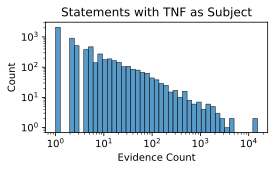

In [5]:
fix, ax = plt.subplots(figsize=(4, 2))
sns.histplot(targets_df["evidences"], log_scale=True, ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Evidence Count")
ax.set_title("Statements with TNF as Subject")
plt.show()

# Polarity of TNF to Apopotosis

In [6]:
%%time
res = client.query_tx(
    """\
    MATCH (:BioEntity {id: "hgnc:11892"})-[r:indra_rel]->(:BioEntity {id: 'go:0006915'})
    MATCH (e:Evidence {stmt_hash: r.stmt_hash})-[:has_citation]->(p:Publication)-[:annotated_with]->(a:BioEntity)
    RETURN r.stmt_hash, r.stmt_type, e, collect({pubmed: p.id, mesh: a.id, name: a.name})
    """
)
res = [
    (stmt_hash, stmt_type, Evidence._from_json(evidence), annotations)
    for stmt_hash, stmt_type, evidence, annotations in res
]

len(res)

CPU times: user 4.66 s, sys: 263 ms, total: 4.92 s
Wall time: 51.2 s


13485

In [7]:
# collect dictionary of stmt -> mesh ID -> pubmed -> evidence
dd = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for stmt_hash, stmt_type, evidence, annotations in res:
    for annotation in annotations:
        mesh_id = annotation["mesh"].removeprefix("mesh:")
        if not is_disease(mesh_id):
            continue
        name = annotation["name"]
        pubmed = annotation["pubmed"].removeprefix("pubmed:")
        dd[stmt_type][mesh_id, name][pubmed].append(evidence)

In [8]:
# 1. aggregate evidences in each publication by total count
# 2. aggregate publications in each mesh annotation by sum of total counts
# 3. apply cutoff for minimum number of annotations
# 4. apply binomial test
# 5. calculate FDR
raw_count_df = get_raw_counts_df(dd, "Activation", "Inhibition", minimum=10)
raw_count_df

INFO: [2023-01-13 16:04:09] indra_cogex.analyses.context_specificity_analysis - using calculated ratio of 0.92


,,Activation,Inhibition,p,q,mlq,sign
D001249,Asthma,19,23,1.796316e-14,4.167454e-12,11.38,-1.0
D015464,"Leukemia, Myelogenous, Chronic, BCR-ABL Positive",11,10,2.679553e-06,3.108282e-04,3.51,-1.0
D001172,"Arthritis, Rheumatoid",153,33,4.999005e-05,3.865898e-03,2.41,-1.0
D016766,Feline Infectious Peritonitis,11,8,8.249351e-05,4.784624e-03,2.32,-1.0
D064726,Triple Negative Breast Neoplasms,26,9,2.006155e-03,9.308559e-02,1.03,-1.0
...,...,...,...,...,...,...,...
D012859,Sjogren's Syndrome,24,2,1.000000e+00,1.000000e+00,-0.00,1.0
D002690,Chlamydia Infections,21,2,1.000000e+00,1.000000e+00,-0.00,-1.0
D009447,Neuroblastoma,46,4,1.000000e+00,1.000000e+00,-0.00,1.0
D058226,"Plaque, Atherosclerotic",17,1,1.000000e+00,1.000000e+00,-0.00,1.0


In [44]:
# 1. aggregate evidences in each publication with a simple belief scorer
# 2. aggregate publications in each mesh annotation by sum of total counts
# 3. apply cutoff for minimum number of annotations
# 4. apply binomial test
# 5. calculate FDR
belief_df = get_norm_counts_df(dd, "Activation", "Inhibition", minimum=10)
belief_df

INFO: [2023-01-13 16:58:58] indra_cogex.analyses.context_specificity_analysis - using calculated ratio of 0.90


,,Activation,Inhibition,p,q,mlq,sign
D001172,"Arthritis, Rheumatoid",66,19,0.001170,0.15215,0.82,-1.0
D000860,Hypoxia,13,5,0.033520,1.00000,-0.00,-1.0
D064726,Triple Negative Breast Neoplasms,13,5,0.033520,1.00000,-0.00,-1.0
D003424,Crohn Disease,17,5,0.072763,1.00000,-0.00,-1.0
D001249,Asthma,8,3,0.099645,1.00000,-0.00,-1.0
...,...,...,...,...,...,...,...
D003921,"Diabetes Mellitus, Experimental",25,2,1.000000,1.00000,-0.00,1.0
D013119,Spinal Cord Injuries,11,1,1.000000,1.00000,-0.00,1.0
D055959,Intervertebral Disc Degeneration,11,1,1.000000,1.00000,-0.00,1.0
D005234,Fatty Liver,16,1,1.000000,1.00000,-0.00,1.0


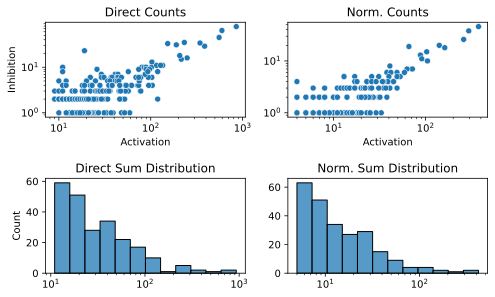

In [10]:
fig, ((lax, rax), (lax0, rax0)) = plt.subplots(2, 2, figsize=(7, 4.3))

sns.histplot(x=raw_count_df["Activation"] + raw_count_df["Inhibition"], log_scale=True, ax=lax0)
lax0.set_title("Direct Sum Distribution")

sns.histplot(x=belief_df["Activation"] + belief_df["Inhibition"], log_scale=True, ax=rax0)
rax0.set_title("Norm. Sum Distribution")
rax0.set_ylabel("")

sns.scatterplot(data=raw_count_df, x="Activation", y="Inhibition", ax=lax)
lax.set_title("Direct Counts")
lax.set_yscale("log")
lax.set_xscale("log")

sns.scatterplot(data=belief_df, x="Activation", y="Inhibition", ax=rax)
rax.set_title("Norm. Counts")
rax.set_ylabel("")
rax.set_yscale("log")
rax.set_xscale("log")

plt.tight_layout()
plt.show()

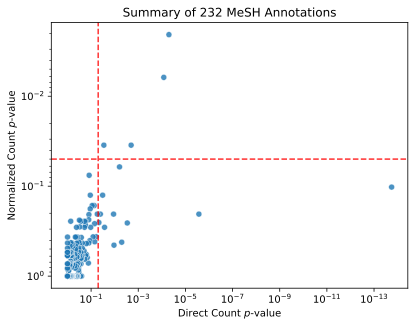

In [11]:
columns = ["p", "mlq", "sign"]
p_cutoff = 0.05
join_df = raw_count_df[columns].join(belief_df[columns], rsuffix="_norm", lsuffix="_direct")
ax = sns.scatterplot(data=join_df, x="p_direct", y="p_norm", alpha=0.8)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Direct Count $p$-value")
ax.set_ylabel("Normalized Count $p$-value")
ax.invert_yaxis()
ax.invert_xaxis()
ax.axvline(p_cutoff, linestyle='--', color='red', alpha=0.8)
ax.axhline(p_cutoff, linestyle='--', color='red', alpha=0.8)
ax.set_title(f'Summary of {len(join_df.index)} MeSH Annotations')
plt.show()

The following MeSH annotations were significant before applying normalization. Notably, this includes Asthma.


There are no situations where something became significant after normalization.

In [12]:
idx = (join_df["p_direct"] < p_cutoff) & (join_df["p_norm"] > p_cutoff) 
join_df[idx].sort_values("p_direct", ascending=True)

,,p_direct,mlq_direct,sign_direct,p_norm,mlq_norm,sign_norm
D001249,Asthma,1.796316e-14,11.38,-1.0,0.102316,-0.0,-1.0
D015464,"Leukemia, Myelogenous, Chronic, BCR-ABL Positive",2.679553e-06,3.51,-1.0,0.204319,-0.0,-1.0
D005909,Glioblastoma,2.917603e-03,0.95,1.0,0.256471,-0.0,1.0
D006528,"Carcinoma, Hepatocellular",5.029465e-03,0.78,-1.0,0.419387,-0.0,-1.0
D015451,"Leukemia, Lymphocytic, Chronic, B-Cell",6.230636e-03,0.74,-1.0,0.061041,-0.0,-1.0
D008113,Liver Neoplasms,1.069683e-02,0.59,-1.0,0.452675,-0.0,-1.0
D002051,Burkitt Lymphoma,1.113846e-02,0.59,-1.0,0.204319,-0.0,-1.0
D006965,Hyperplasia,2.686795e-02,0.26,-1.0,0.286436,-0.0,-1.0
D008232,Lymphoproliferative Disorders,3.243257e-02,0.24,-1.0,0.125863,-0.0,-1.0
D001168,Arthritis,4.042993e-02,0.17,-1.0,0.204319,-0.0,-1.0


The following are significantly different between activation/inhibition even after applying normalization, representing the highest confident differential conditions.

In [13]:
idx = (join_df["p_direct"] < p_cutoff) & (join_df["p_norm"] < p_cutoff)
join_df[idx].sort_values("p_direct", ascending=True)

,,p_direct,mlq_direct,sign_direct,p_norm,mlq_norm,sign_norm
D001172,"Arthritis, Rheumatoid",0.000050,2.41,-1.0,0.002066,0.30,-1.0
D016766,Feline Infectious Peritonitis,0.000082,2.32,-1.0,0.006171,0.13,-1.0
D064726,Triple Negative Breast Neoplasms,0.002006,1.03,-1.0,0.034988,-0.00,-1.0
D000860,Hypoxia,0.028731,0.26,-1.0,0.034988,-0.00,-1.0


# Process vs. Process

later: look at different objects TNF activates differentiation vs. inflammatory response vs. apopotsis with different endpoints

In [14]:
@lru_cache
def _get_res(target_curie):
    return [
        (stmt_hash, Evidence._from_json(evidence), annotations)
        for stmt_hash, evidence, annotations in client.query_tx(
            """\
            MATCH (:BioEntity {id: "hgnc:11892"})-[r:indra_rel {stmt_type: 'Activation'}]->(:BioEntity {id: '%s'})
            MATCH (e:Evidence {stmt_hash: r.stmt_hash})-[:has_citation]->(p:Publication)-[:annotated_with]->(a:BioEntity)
            RETURN r.stmt_hash, e, collect({pubmed: p.id, mesh: a.id, name: a.name})
            """ % target_curie
        )
    ]

In [35]:
# collect dictionary of target -> mesh ID -> pubmed -> evidence
cross_dd = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
c1, c2 = 'apoptotic process', 'inflammatory response'
for target_curie, target_name in [
    ('go:0006915', 'apoptotic process'),
    ('go:0006954', 'inflammatory response'),
    # ('go:0008219', 'cell death'),
    # ('go:0008283', 'cell population proliferation'),
]:    
    for stmt_hash, evidence, annotations in _get_res(target_curie):
        for annotation in annotations:
            mesh_id = annotation["mesh"].removeprefix("mesh:")
            if not is_disease(mesh_id):
                continue
            if mesh_id in {
                "D007249",  # inflammation, skip since redundant
            }:
                continue
            name = annotation["name"]
            pubmed = annotation["pubmed"].removeprefix("pubmed:")
            cross_dd[target_name][mesh_id, name][pubmed].append(evidence)

In [36]:
cross_raw_counts_df = get_raw_counts_df(cross_dd, c1, c2, minimum=10)
cross_raw_counts_df

INFO: [2023-01-13 16:14:55] indra_cogex.analyses.context_specificity_analysis - using calculated ratio of 0.71


,,apoptotic process,inflammatory response,p,q,mlq,sign
D001943,Breast Neoplasms,344,14,3.642940e-35,1.067381e-32,31.97,1.0
D011471,Prostatic Neoplasms,249,6,1.045509e-29,1.531671e-27,26.81,1.0
D009765,Obesity,38,108,1.111561e-28,1.085624e-26,25.96,-1.0
D004195,"Disease Models, Animal",596,481,2.560159e-26,1.875317e-24,23.73,-1.0
D009369,Neoplasms,555,84,4.966041e-22,2.910100e-20,19.54,1.0
...,...,...,...,...,...,...,...
D001927,Brain Diseases,11,4,1.000000e+00,1.000000e+00,-0.00,1.0
D011183,Postoperative Complications,8,3,1.000000e+00,1.000000e+00,-0.00,1.0
D001424,Bacterial Infections,23,9,1.000000e+00,1.000000e+00,-0.00,1.0
D007035,Hypothermia,16,6,1.000000e+00,1.000000e+00,-0.00,1.0


In [40]:
cross_norm_counts_df = get_norm_counts_df(cross_dd, c1, c2, minimum=10)
cross_norm_counts_df.head(25)

INFO: [2023-01-13 16:16:08] indra_cogex.analyses.context_specificity_analysis - using calculated ratio of 0.67


,,apoptotic process,inflammatory response,p,q,mlq,sign
D001943,Breast Neoplasms,141,9,1.830616e-15,3.350027e-13,12.47,1.0
D009765,Obesity,22,63,1.505496e-14,1.377529e-12,11.86,-1.0
D011471,Prostatic Neoplasms,105,4,6.262001e-14,3.819821e-12,11.42,1.0
D009369,Neoplasms,260,48,4.099500e-12,1.875521e-10,9.73,1.0
D011014,Pneumonia,7,33,1.885504e-10,6.900945e-09,8.16,-1.0
D009336,Necrosis,162,25,7.437312e-10,2.254167e-08,7.65,1.0
D007333,Insulin Resistance,23,50,8.622495e-10,2.254167e-08,7.65,-1.0
D004195,"Disease Models, Animal",295,249,1.130660e-09,2.586385e-08,7.59,-1.0
D008175,Lung Neoplasms,91,8,5.525882e-09,1.123596e-07,6.95,1.0
D010051,Ovarian Neoplasms,49,1,6.851309e-08,1.253790e-06,5.90,1.0


themes:
- cancers (e.g., breast, prostate, lung, ovarian, liver) show bias towards apoptotic process
- inflammatory disease (arthritis)
- diseases associated with inflammation (athersclerosis, insulin resistance)
    
    
Asthma - TNF directly implicated in disease ()

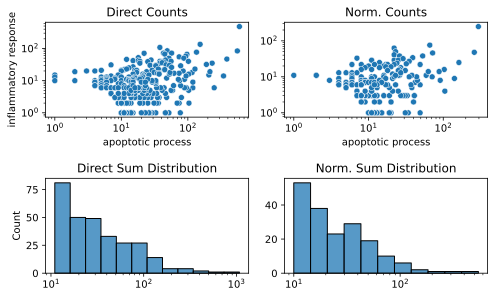

In [38]:
fig, ((lax, rax), (lax0, rax0)) = plt.subplots(2, 2, figsize=(7, 4.3))

sns.histplot(x=cross_raw_counts_df[c1] + cross_raw_counts_df[c2], log_scale=True, ax=lax0)
lax0.set_title("Direct Sum Distribution")

sns.histplot(x=cross_norm_counts_df[c1] + cross_norm_counts_df[c2], log_scale=True, ax=rax0)
rax0.set_title("Norm. Sum Distribution")
rax0.set_ylabel("")

sns.scatterplot(data=cross_raw_counts_df, x=c1, y=c2, ax=lax)
lax.set_title("Direct Counts")
lax.set_yscale("log")
lax.set_xscale("log")

sns.scatterplot(data=cross_norm_counts_df, x=c1, y=c2, ax=rax)
rax.set_title("Norm. Counts")
rax.set_ylabel("")
rax.set_yscale("log")
rax.set_xscale("log")

plt.tight_layout()
plt.show()

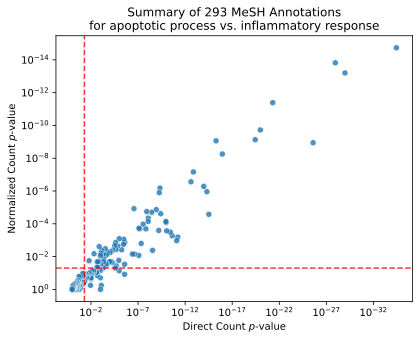

In [41]:
columns = ["p", "mlq", "sign"]
p_cutoff = 0.05
cross_join_df = cross_raw_counts_df[columns].join(
    cross_norm_counts_df[columns], rsuffix="_norm", lsuffix="_direct"
)
ax = sns.scatterplot(
    data=cross_join_df, 
    x="p_direct", y="p_norm", 
    alpha=0.8,
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Direct Count $p$-value")
ax.set_ylabel("Normalized Count $p$-value")
ax.invert_yaxis()
ax.invert_xaxis()
ax.axvline(p_cutoff, linestyle='--', color='red', alpha=0.8)
ax.axhline(p_cutoff, linestyle='--', color='red', alpha=0.8)
ax.set_title(f'Summary of {len(cross_join_df.index)} MeSH Annotations\nfor {c1} vs. {c2}')
plt.show()